### 하나의 렌즈로 shallow focusing 구현하기  
1. 배경이 있는 셀카 촬영
2. semantic segmentation 으로 피사체와 배경 분리
3. blurring 기술로 배경을 흐리게
4. 피사체를 배경의 원래 위치에 합성

In [22]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

이미지 크기 : (1472, 1104, 3)


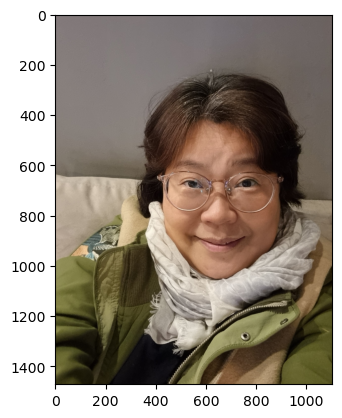

In [23]:
img_path = "./images/image05.jpg"
img_orig = cv2.imread(img_path)

print(f"이미지 크기 : {img_orig.shape}")

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# Semantic segmentation
- 실제 세계처럼 물리적 의미 단위로 인식하는 segmentation
- 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류하는 방법

### Instance segmentation
- 사람 개개인별로 다른 라벨을 가지도록 하여 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하는 segmentation

### DeepLab
- atrous convolution 활용
    - 기존 Convolution과 다르게 filter(kernel) 내부에 빈 공간을 둔 채로 작동하게 됨
    - filter 내부의 각각의 요소 사이에 빈 공간은 r 이라는 하이퍼 파라미터에 의해 결정됨
    - r=1 이면 기존 convolution과 같음
    - 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서도, field of view(한 픽셀이 볼 수 있는 영역)를 크게 가져갈 수 있음
    - 즉, filter가 더 넓은 영역을 볼 수 있음

In [24]:
model = deeplabv3_resnet101(pretrained=True).eval()

이미지 처리 인공지능 모델 중 pretrained 모델은 모델의 전처리 방식과 입력 크기 등을 사전 학습에 사용한 것과 동일하게 사용해야 함

In [25]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
])

In [26]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [27]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(
                                        output_predictions, 
                                        (img_orig.shape[1], img_orig.shape[0]),
                                        interpolation=cv2.INTER_NEAREST
                                        )

CPU times: total: 10.9 s
Wall time: 983 ms


### PASCAL VOC
- DeepLab 모델을 불러올 때 VOC와 관련된 출력을 확인할 수 있음
- PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미

In [28]:
# pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

21

이 중 사람(person) 라벨, 즉 15를 가진 영역만 detection하면 됨

우선, deeplab 모델을 통해 나온 출력값을 살펴보자

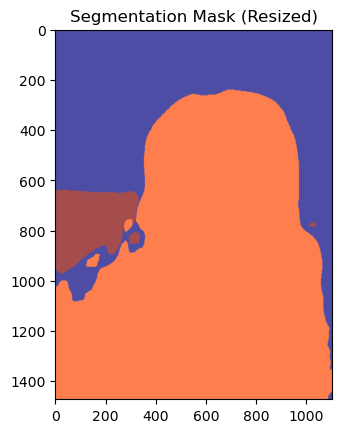

In [29]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [30]:
# 출력값에서 모델이 detection한 label 확인 
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15, 18], dtype=uint8)

In [31]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person
sofa


In [32]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [33]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

사람 외에도 다른 물체의 색상을 찾아내고 싶다면 colormap[class_id] 를 통해 확인 가능

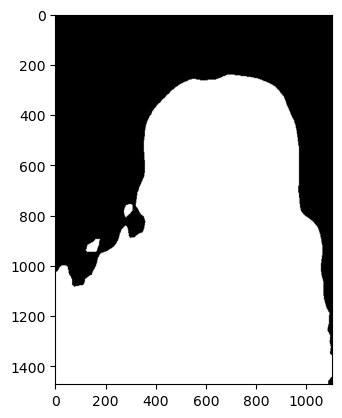

In [34]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

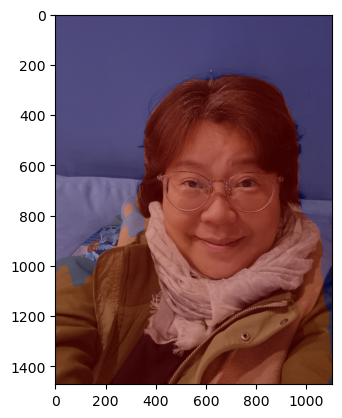

In [35]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# Blur the background

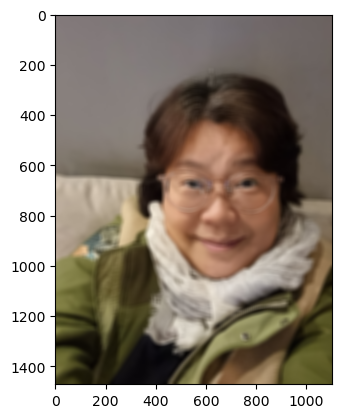

In [36]:
# (13, 13) : blurring kernel size
img_orig_blur = cv2.blur(img_orig, (20, 20))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 segmentation mask를 이용하여 배경 추출

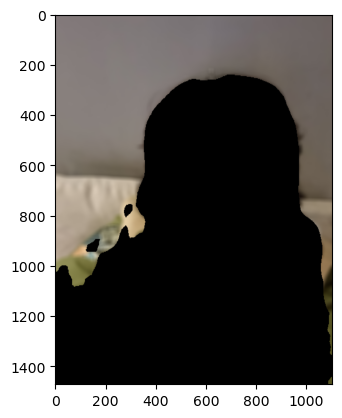

In [37]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not() : 이미지 반전
# 배경 0 사람 255 -> 배경 255 사람 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and() : img_mask_color와 img_bg_mask를 and연산하여 배경만 남김
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# Convolution bg and label

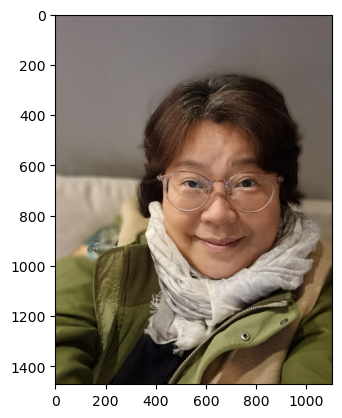

In [38]:
# np.where(조건, 참일 때, 거짓일 때)
# segemetation mask가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 blur된 이미지 값을 사용
img_concat = np.where(
                      img_mask_color==255,
                      img_orig,
                      img_bg_blur
                      )

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()